In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization purposes
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


In [2]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler1=StandardScaler()
scaler2=MinMaxScaler()
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.pipeline import Pipeline
 
from sklearn.decomposition import PCA
 
from sklearn.model_selection import TimeSeriesSplit
 
from sklearn.feature_selection import SelectPercentile, f_regression

In [3]:
# Create the DataFrame 'df' with the 'Month' column
# Load the data into a pandas dataframe
df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)

In [5]:
X = df[['Temperature','Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
        'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y = df['PowerConsumption_Zone1']

In [6]:
train, test = df[df['Month']<=10], df[df['Month']>10]

X_train = train[['Temperature','Holiday',  'Humidity', 'WindSpeed', 'GeneralDiffuseFlows','DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_train = np.sqrt(train['PowerConsumption_Zone1'])

X_test = test[['Temperature','Holiday',  'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_test = np.sqrt(test['PowerConsumption_Zone1'])

In [7]:
tscv = TimeSeriesSplit( max_train_size=4320*3, n_splits=8,test_size=4320)# 144 samples per day * 30 days = 4320 samples

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# Define the feature selection and regression steps in the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
       ('feature_selection', SelectKBest(f_regression, k=5)),
    ('knn', KNeighborsRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}


In [9]:
# Do the GridSearchCV (Cross-Validation + Hyperparameter Tuning)
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv)

In [26]:
### 不确定是否需要保留
X_train_scaled = scaler1.fit_transform(X_train)
X_test_scaled = scaler1.fit_transform(X_test)

In [27]:
### 不确定是否需要保留
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['Temperature', 'Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Temperature', 'Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season'])

In [10]:
model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=12960, n_splits=8, test_size=4320),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k=5,
                                                    score_func=<function f_regression at 0x0000016AF2FE64D0>)),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']})

In [11]:

# Retrieve the best model and print the best hyperparameters
best_model = model.best_estimator_
print("Best Hyperparameters:", model.best_params_)

# Use the best model to predict on the validation fold
y_pred = best_model.predict(X_test)

# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

Best Hyperparameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
MSE: 112.35336952426178
MAE: 8.40132827695996
R-squared: 0.6415974169521382


In [12]:
# Access the SelectKBest object from the pipeline
select_kbest = best_model.named_steps['feature_selection']

# Get the selected features using get_support() method
selected_features = X_train.columns[select_kbest.get_support()].tolist()

# Print the selected features
print("Selected Features:", selected_features)

Selected Features: ['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour']


## residual plot

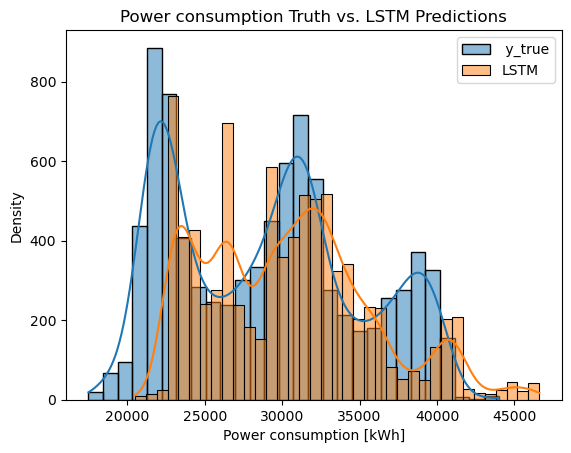

In [17]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='LSTM', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. LSTM Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

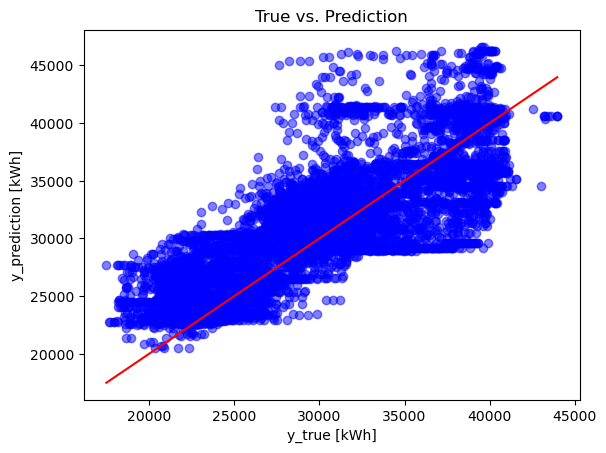

In [18]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

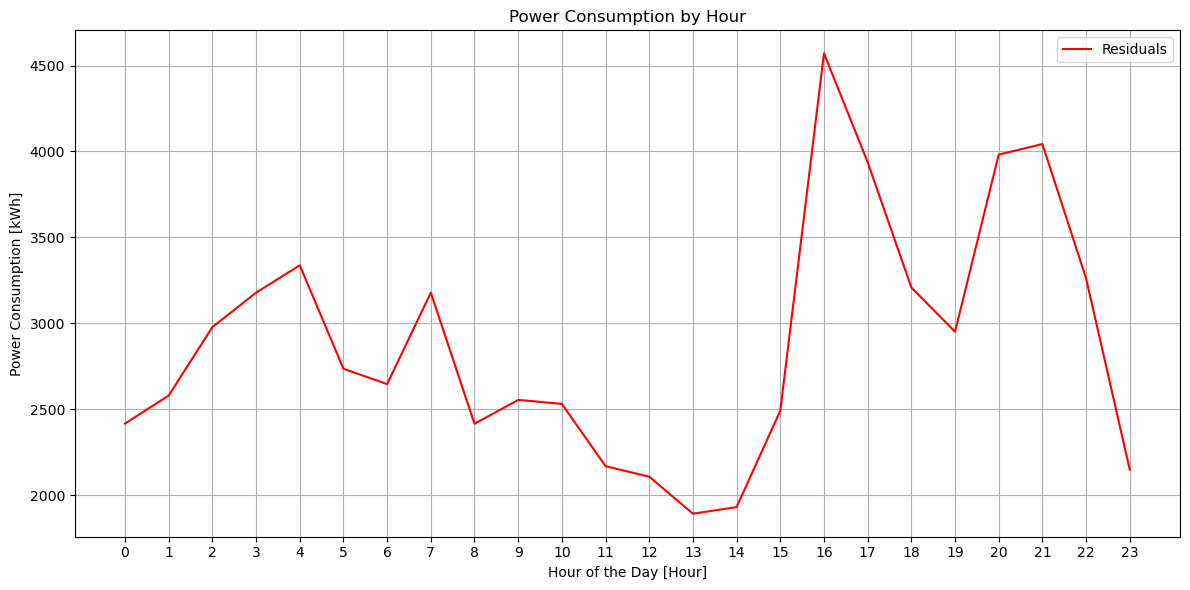

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


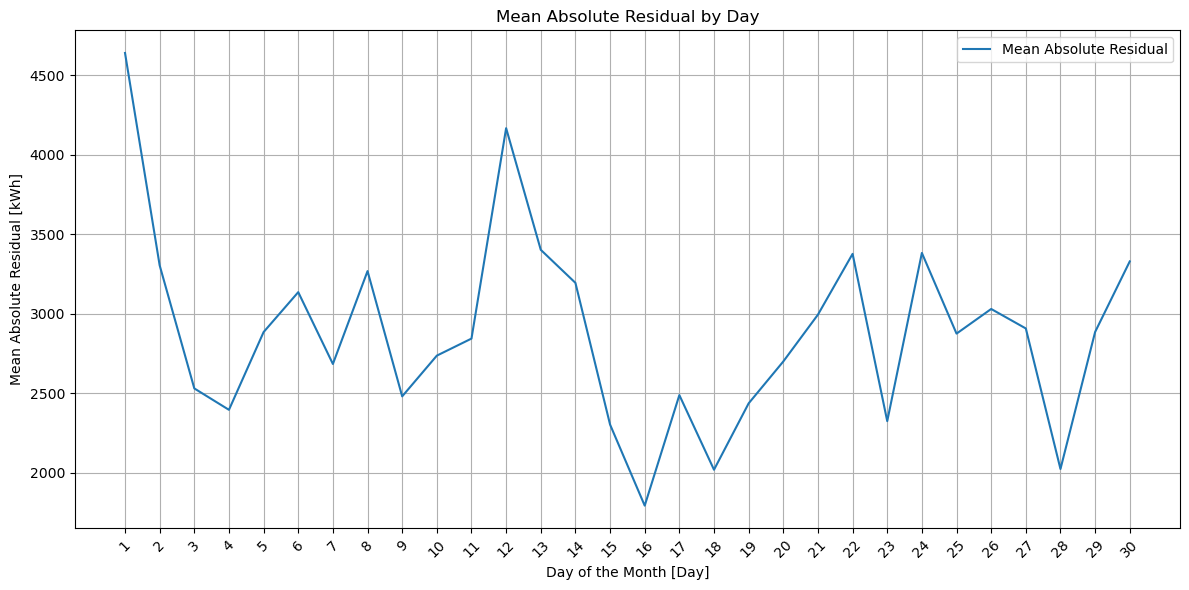

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the Month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## min max scaler

In [21]:
# Define the feature selection and regression steps in the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
       ('feature_selection', SelectKBest(f_regression, k=5)),
    ('knn', KNeighborsRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}


In [22]:
# Do the GridSearchCV (Cross-Validation + Hyperparameter Tuning)
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv)

In [23]:
model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=12960, n_splits=8, test_size=4320),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('feature_selection',
                                        SelectKBest(k=5,
                                                    score_func=<function f_regression at 0x0000016AF2FE64D0>)),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']})

In [24]:

# Retrieve the best model and print the best hyperparameters
best_model = model.best_estimator_
print("Best Hyperparameters:", model.best_params_)

# Use the best model to predict on the validation fold
y_pred = best_model.predict(X_test)

# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

Best Hyperparameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
MSE: 90.67658475104669
MAE: 7.548190103683604
R-squared: 0.7107454601998772


In [25]:

# Access the SelectKBest object from the pipeline
select_kbest = best_model.named_steps['feature_selection']

# Get the selected features using get_support() method
selected_features = X_train.columns[select_kbest.get_support()].tolist()

# Print the selected features
print("Selected Features:", selected_features)

Selected Features: ['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour']


## residual plot

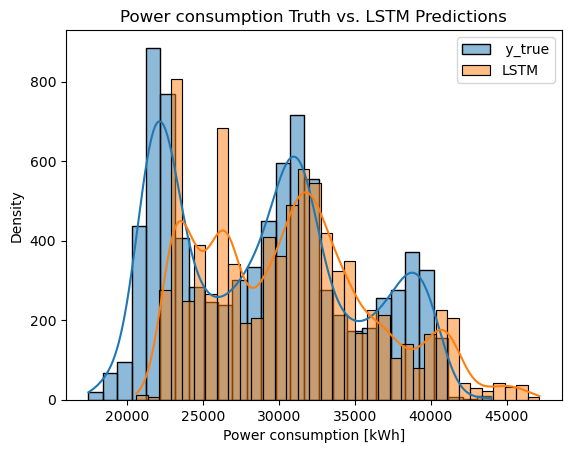

In [26]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='LSTM', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. LSTM Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

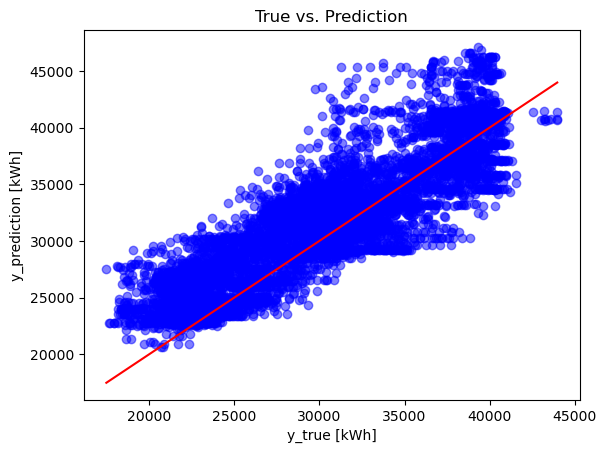

In [27]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

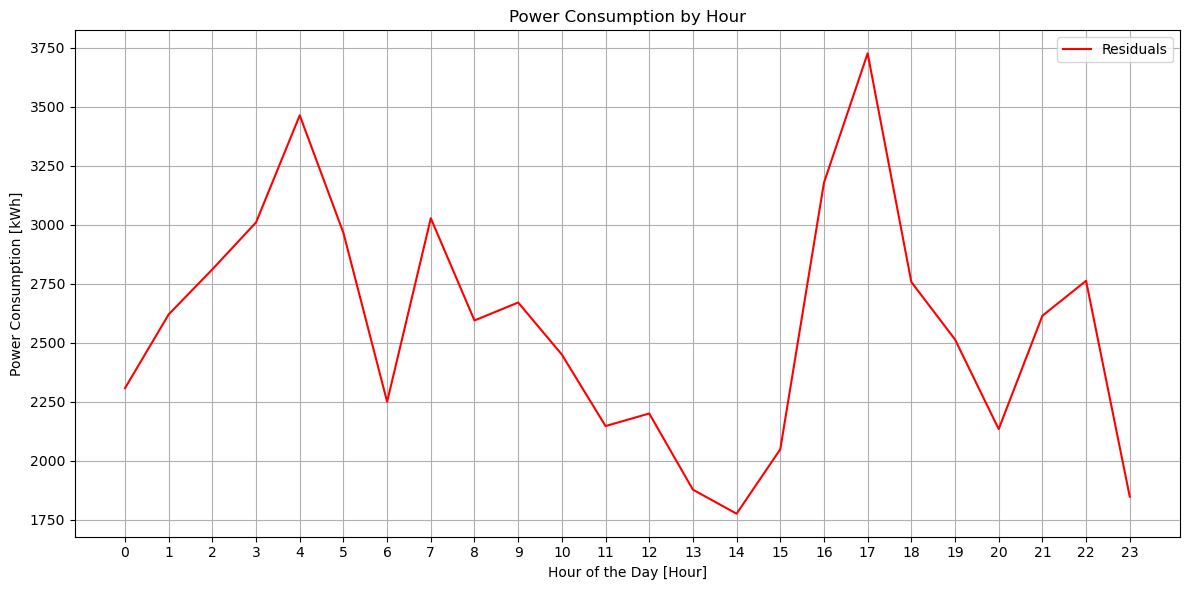

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


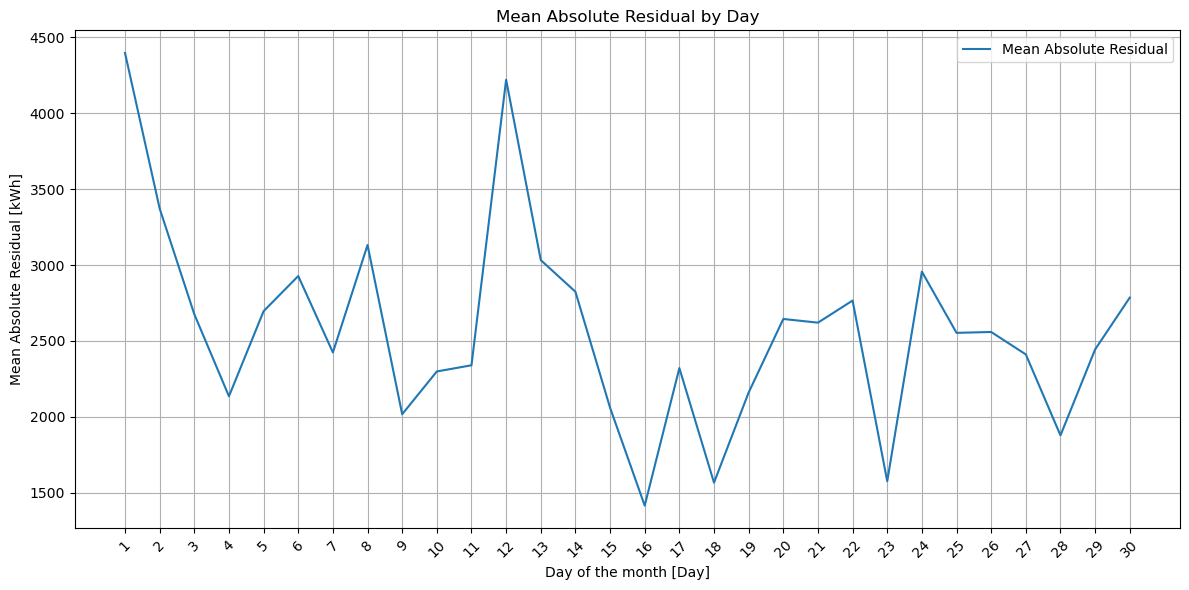

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
